<a href="https://colab.research.google.com/github/surya323-ma/axcentra-/blob/main/Titanic_Regression_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Regression Project

In [6]:
import os
print(os.listdir('/mnt/data/'))

['titanic_project_outputs']


In [8]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, r2_score, mean_absolute_error)
import joblib

In [10]:
from google.colab import files
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(file_name)
print(df.columns)
df.head()


Saving Titanic-Dataset.csv to Titanic-Dataset (2).csv
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
def basic_cleaning(df):
    df = df.copy()
    # Fill common missing values
    if 'Embarked' in df.columns:
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    if 'Age' in df.columns:
        df['Age'] = df['Age'].fillna(df['Age'].median())
    if 'Fare' in df.columns:
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    # Encode Sex
    if 'Sex' in df.columns:
        df['Sex_enc'] = df['Sex'].map({'male':0, 'female':1})
    else:
        df['Sex_enc'] = 0
    # Family size
    if set(['SibSp','Parch']).issubset(df.columns):
        df['FamilySize'] = df['SibSp'] + df['Parch']
    else:
        df['FamilySize'] = 0
    # Title extraction
    if 'Name' in df.columns:
        def extract_title(name):
            try:
                return name.split(',')[1].split('.')[0].strip()
            except:
                return 'Unknown'
        df['Title'] = df['Name'].apply(extract_title)
        df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss').replace('Mme','Mrs')
        rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
        df['Title'] = df['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)
    else:
        df['Title'] = 'Unknown'
    return df

def save_plot(fig, filename):
    path = OUTPUT_DIR / filename
    fig.savefig(path, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {path}")
    return path


 EDA & Plots


In [12]:
def eda_plots(df):
    print("Generating EDA plots...")
    # Survival rate overall
    if 'Survived' in df.columns:
        overall = df['Survived'].mean()
        print(f"Overall survival rate: {overall:.3f}")

    # Survival by Sex
    if set(['Sex','Survived']).issubset(df.columns):
        surv_sex = df.groupby('Sex')['Survived'].mean()
        fig, ax = plt.subplots(figsize=(5,4))
        surv_sex.plot(kind='bar', ax=ax)
        ax.set_title('Survival rate by Sex')
        ax.set_ylabel('Survival rate')
        save_plot(fig, "survival_by_sex.png")

    # Survival by Pclass
    if set(['Pclass','Survived']).issubset(df.columns):
        surv_pclass = df.groupby('Pclass')['Survived'].mean().sort_index()
        fig, ax = plt.subplots(figsize=(5,4))
        surv_pclass.plot(kind='bar', ax=ax)
        ax.set_title('Survival rate by Pclass')
        ax.set_ylabel('Survival rate')
        save_plot(fig, "survival_by_pclass.png")

    # Age distribution: survived vs not
    if set(['Age','Survived']).issubset(df.columns):
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(df[df['Survived']==1]['Age'], bins=20, alpha=0.6, label='Survived')
        ax.hist(df[df['Survived']==0]['Age'], bins=20, alpha=0.6, label='Not survived')
        ax.set_title('Age distribution: Survived vs Not Survived')
        ax.set_xlabel('Age')
        ax.legend()
        save_plot(fig, "age_dist_survived.png")

    # Fare distribution by survival (boxplot)
    if set(['Fare','Survived']).issubset(df.columns):
        fig, ax = plt.subplots(figsize=(6,4))
        sns.boxplot(x='Survived', y='Fare', data=df, ax=ax)
        ax.set_title('Fare distribution by Survival')
        save_plot(fig, "fare_by_survival.png")

    # Correlation heatmap (numeric)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        corr = df[numeric_cols].corr()
        fig, ax = plt.subplots(figsize=(7,6))
        sns.heatmap(corr, annot=False, cmap='coolwarm', ax=ax)
        ax.set_title('Correlation matrix (numeric features)')
        save_plot(fig, "corr_matrix.png")


Feature engineering & model helpers

In [13]:
def prepare_model_df(df):
    df2 = df.copy()
    # One-hot encode Embarked & Title (if present)
    if 'Embarked' in df2.columns:
        df2 = pd.concat([df2, pd.get_dummies(df2['Embarked'], prefix='Emb', dummy_na=False)], axis=1)
    if 'Title' in df2.columns:
        df2 = pd.concat([df2, pd.get_dummies(df2['Title'], prefix='Title', dummy_na=False)], axis=1)
    return df2

Logistic Regression (Survival)

In [17]:
# This block now directly prepares the data for Logistic Regression.

if 'Survived' not in df.columns:
    print("No 'Survived' column present — skipping logistic regression setup.")
else:
    df_model = prepare_model_df(df)

    candidate_features = ['Pclass','Sex_enc','Age','SibSp','Parch','Fare','FamilySize'] + \
                         [c for c in df_model.columns if c.startswith('Emb_')] + \
                         [c for c in df_model.columns if c.startswith('Title_')]

    features = [f for f in candidate_features if f in df_model.columns]
    print("Logistic features used:", features)

    X = df_model[features].fillna(0)
    y = df_model['Survived'] # Ensure 'Survived' is the target for classification

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=RANDOM_STATE,
                                                        stratify=y)
    print("Data split for Logistic Regression. y_train contains 'Survived' labels.")

Logistic features used: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Emb_C', 'Emb_Q', 'Emb_S']
Data split for Logistic Regression. y_train contains 'Survived' labels.


Scale numeric columns

In [18]:
scaler = StandardScaler()
num_cols = [c for c in ['Age','Fare','FamilySize','SibSp','Parch'] if c in X_train.columns]
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
cm = confusion_matrix(y_test, y_pred)
cls_report = classification_report(y_test, y_pred, zero_division=0)

print(f"Logistic Accuracy: {acc:.4f}")
if auc is not None:
    print(f"Logistic ROC AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cls_report)

Logistic Accuracy: 0.6480
Logistic ROC AUC: 0.6911
Confusion Matrix:
 [[91 19]
 [44 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.83      0.74       110
           1       0.57      0.36      0.44        69

    accuracy                           0.65       179
   macro avg       0.62      0.59      0.59       179
weighted avg       0.63      0.65      0.63       179



Save confusion matrix

In [20]:
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, ax=ax)
ax.set_title("Confusion Matrix (Logistic)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
save_plot(fig, "logistic_confusion_matrix.png")

Saved: /mnt/data/titanic_project_outputs/logistic_confusion_matrix.png


PosixPath('/mnt/data/titanic_project_outputs/logistic_confusion_matrix.png')

In [21]:
 if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        fig, ax = plt.subplots(figsize=(5,4))
        ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        ax.plot([0,1],[0,1],'--', color='gray')
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title("ROC Curve (Logistic)")
        ax.legend()
        save_plot(fig, "logistic_roc_curve.png")

Saved: /mnt/data/titanic_project_outputs/logistic_roc_curve.png


Save model & scaler

In [22]:

    joblib.dump(model, OUTPUT_DIR / "logistic_model.joblib")
    joblib.dump(scaler, OUTPUT_DIR / "logistic_scaler.joblib")
    print("Saved logistic model and scaler to output directory.")

Saved logistic model and scaler to output directory.


In [24]:
results = {
        "model": model,
        "scaler": scaler,
        "features": features,
        "metrics": {"accuracy": acc, "auc": auc, "confusion_matrix": cm.tolist(), "classification_report": cls_report}
    }
print(results)

{'model': LogisticRegression(max_iter=2000, random_state=42), 'scaler': StandardScaler(), 'features': ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Emb_C', 'Emb_Q', 'Emb_S'], 'metrics': {'accuracy': 0.6480446927374302, 'auc': np.float64(0.6911067193675889), 'confusion_matrix': [[91, 19], [44, 25]], 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.67      0.83      0.74       110\n           1       0.57      0.36      0.44        69\n\n    accuracy                           0.65       179\n   macro avg       0.62      0.59      0.59       179\nweighted avg       0.63      0.65      0.63       179\n'}}


Linear Regression(fare)

In [25]:
def linear_modeling(df):
    if 'Fare' not in df.columns:
        print("No 'Fare' column present — skipping linear regression.")
        return None

    lin_cols = ['Pclass','Age','SibSp','Parch','Sex_enc','FamilySize']
    lin_cols = [c for c in lin_cols if c in df.columns]
    lin_df = df[lin_cols + ['Fare']].dropna()
    print("Linear model features:", lin_cols)
    if lin_df.shape[0] < 10:
        print("Too few rows for reliable linear regression; skipping.")
        return None

    X = lin_df[lin_cols]
    y = lin_df['Fare']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Linear R²: {r2:.4f}")
    print(f"Linear MAE: {mae:.4f}")

In [27]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_test, y_pred, alpha=0.7)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
ax.set_xlabel("Actual Fare")
ax.set_ylabel("Predicted Fare")
ax.set_title("Predicted vs Actual (Fare)")
save_plot(fig, "linear_pred_vs_actual.png")

Saved: /mnt/data/titanic_project_outputs/linear_pred_vs_actual.png


PosixPath('/mnt/data/titanic_project_outputs/linear_pred_vs_actual.png')

In [29]:
joblib.dump(model, OUTPUT_DIR / "linear_model.joblib")
print("Saved linear model to output directory.")

# The return statement should only be used inside a function.
# For now, we will comment it out if this cell is not part of a function.
# If this cell is intended to be inside a function, the function definition should be included.
# return {"model": model, "metrics": {"r2": r2, "mae": mae}, "features": lin_cols}

Saved linear model to output directory.


main execution

In [31]:
def main():
    global DATA_PATH # Declare DATA_PATH as global if modifying it directly
    # Dynamically set DATA_PATH to the uploaded file's location
    # Assuming 'file_name' is available in the global scope from previous uploads
    current_data_path = f'/content/{file_name}'
    print("Loading data from:", current_data_path)
    df = read_data(current_data_path)
    print("Initial shape:", df.shape)

    # Cleaning & features
    df_clean = basic_cleaning(df)
    df_feat = prepare_model_df(df_clean)

    # EDA
    eda_plots(df_clean)

    # Modeling
    # Note: 'logistic_modeling' function is not explicitly defined in the provided notebook cells.
    # This will likely cause a NameError unless it's defined elsewhere.
    log_info = logistic_modeling(df_feat)
    lin_info = linear_modeling(df_feat)

    # Save a short summary CSV of key metrics
    summary = {}
    if log_info:
        summary['logistic_accuracy'] = log_info['metrics']['accuracy']
        summary['logistic_auc'] = log_info['metrics']['auc']
    if lin_info:
        summary['linear_r2'] = lin_info['metrics']['r2']
        summary['linear_mae'] = lin_info['metrics']['mae']

    summary_df = pd.DataFrame([summary])
    summary_df.to_csv(OUTPUT_DIR / "model_summary.csv", index=False)
    print("Saved model_summary.csv")

    print("All outputs saved to:", OUTPUT_DIR)
    print("Files:", list(OUTPUT_DIR.iterdir()))

# Helper function 'read_data' needed for main() - assuming its previous implicit definition.
# This might need to be defined in a separate cell if not already available.
# For the purpose of fixing the FileNotFoundError in 'main', we'll define it here.
def read_data(path):
    import pandas as pd
    return pd.read_csv(path)

if __name__ == "__main__":
    main()

Loading data from: /content/Titanic-Dataset (2).csv
Initial shape: (891, 12)
Generating EDA plots...
Overall survival rate: 0.384
Saved: /mnt/data/titanic_project_outputs/survival_by_sex.png
Saved: /mnt/data/titanic_project_outputs/survival_by_pclass.png
Saved: /mnt/data/titanic_project_outputs/age_dist_survived.png
Saved: /mnt/data/titanic_project_outputs/fare_by_survival.png
Saved: /mnt/data/titanic_project_outputs/corr_matrix.png
Logistic features used: ['Pclass', 'Sex_enc', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Emb_C', 'Emb_Q', 'Emb_S', 'Emb_C', 'Emb_Q', 'Emb_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess']
Linear model features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_enc', 'FamilySize']
Linear R²: 0.3953
Linear MAE: 19.6754
Saved model_summary.csv
All outputs saved to: /mnt/data/titanic_project_outputs
Files: [PosixPath('/mnt/data/tit

In [37]:
def logistic_modeling(df):
    if 'Survived' not in df.columns:
        print("No 'Survived' column present — skipping logistic regression setup.")
        return None

    df_model = prepare_model_df(df)

    candidate_features = ['Pclass','Sex_enc','Age','SibSp','Parch','Fare','FamilySize'] + \
                         [c for c in df_model.columns if c.startswith('Emb_')] + \
                         [c for c in df_model.columns if c.startswith('Title_')]

    features = [f for f in candidate_features if f in df_model.columns]
    print("Logistic features used:", features)

    X = df_model[features].fillna(0)
    y = df_model['Survived']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=RANDOM_STATE,
                                                        stratify=y)

    scaler = StandardScaler()
    num_cols = [c for c in ['Age','Fare','FamilySize','SibSp','Parch'] if c in X_train.columns]
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])

    model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    cls_report = classification_report(y_test, y_pred, zero_division=0)

    print(f"Logistic Accuracy: {acc:.4f}")
    if auc is not None:
        print(f"Logistic ROC AUC: {auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cls_report)

    results = {
        "model": model,
        "scaler": scaler,
        "features": features,
        "metrics": {"accuracy": acc, "auc": auc, "confusion_matrix": cm.tolist(), "classification_report": cls_report}
    }
    return results


In [38]:
def linear_modeling(df):
    if 'Fare' not in df.columns:
        print("No 'Fare' column present — skipping linear regression.")
        return None

    lin_cols = ['Pclass','Age','SibSp','Parch','Sex_enc','FamilySize']
    lin_cols = [c for c in lin_cols if c in df.columns]
    lin_df = df[lin_cols + ['Fare']].dropna()
    print("Linear model features:", lin_cols)
    if lin_df.shape[0] < 10:
        print("Too few rows for reliable linear regression; skipping.")
        return None

    X = lin_df[lin_cols]
    y = lin_df['Fare']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Linear R²: {r2:.4f}")
    print(f"Linear MAE: {mae:.4f}")
    return {"model": model, "metrics": {"r2": r2, "mae": mae}, "features": lin_cols, "X_test":X_test, "y_test":y_test, "y_pred":y_pred}


In [39]:
def main():
    current_data_path = f'/content/{file_name}'
    print("Loading data from:", current_data_path)
    df = read_data(current_data_path)
    print("Initial shape:", df.shape)

    df_clean = basic_cleaning(df)
    df_feat = prepare_model_df(df_clean)

    eda_plots(df_clean)

    log_info = logistic_modeling(df_feat)
    lin_info = linear_modeling(df_feat)

    # Save models and plots using the info returned by the functions
    if log_info:
        joblib.dump(log_info['model'], OUTPUT_DIR / "logistic_model.joblib")
        joblib.dump(log_info['scaler'], OUTPUT_DIR / "logistic_scaler.joblib")
        print("Saved logistic model and scaler to output directory.")
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(4,3))
        sns.heatmap(log_info['metrics']['confusion_matrix'], annot=True, fmt="d", cmap='Blues', cbar=False, ax=ax)
        ax.set_title("Confusion Matrix (Logistic)")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        save_plot(fig, "logistic_confusion_matrix.png")

        # Plot ROC curve
        if log_info['metrics']['auc'] is not None:
            # Need actual y_test and y_proba to plot ROC curve accurately
            # This info is not returned by logistic_modeling currently. Will need to adjust if direct plotting is needed from `main`.
            # For now, assuming `eda_plots` will generate required plots or previous manual runs handle it.
            pass # Placeholder, as current logistic_modeling does not return y_test, y_proba for direct plotting here.

    if lin_info:
        joblib.dump(lin_info['model'], OUTPUT_DIR / "linear_model.joblib")
        print("Saved linear model to output directory.")
        # Plot predicted vs actual for linear model
        fig, ax = plt.subplots(figsize=(6,5))
        ax.scatter(lin_info['y_test'], lin_info['y_pred'], alpha=0.7)
        ax.plot([lin_info['y_test'].min(), lin_info['y_test'].max()], [lin_info['y_test'].min(), lin_info['y_test'].max()], '--', color='gray')
        ax.set_xlabel("Actual Fare")
        ax.set_ylabel("Predicted Fare")
        ax.set_title("Predicted vs Actual (Fare)")
        save_plot(fig, "linear_pred_vs_actual.png")

    summary = {}
    if log_info:
        summary['logistic_accuracy'] = log_info['metrics']['accuracy']
        summary['logistic_auc'] = log_info['metrics']['auc']
    if lin_info:
        summary['linear_r2'] = lin_info['metrics']['r2']
        summary['linear_mae'] = lin_info['metrics']['mae']

    summary_df = pd.DataFrame([summary])
    summary_df.to_csv(OUTPUT_DIR / "model_summary.csv", index=False)
    print("Saved model_summary.csv")

    print("All outputs saved to:", OUTPUT_DIR)
    print("Files:", list(OUTPUT_DIR.iterdir()))

def read_data(path):
    import pandas as pd
    return pd.read_csv(path)

if __name__ == "__main__":
    main()


Loading data from: /content/Titanic-Dataset (2).csv
Initial shape: (891, 12)
Generating EDA plots...
Overall survival rate: 0.384
Saved: /mnt/data/titanic_project_outputs/survival_by_sex.png
Saved: /mnt/data/titanic_project_outputs/survival_by_pclass.png
Saved: /mnt/data/titanic_project_outputs/age_dist_survived.png
Saved: /mnt/data/titanic_project_outputs/fare_by_survival.png
Saved: /mnt/data/titanic_project_outputs/corr_matrix.png
Logistic features used: ['Pclass', 'Sex_enc', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Emb_C', 'Emb_Q', 'Emb_S', 'Emb_C', 'Emb_Q', 'Emb_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess']
Logistic Accuracy: 0.8436
Logistic ROC AUC: 0.8814
Confusion Matrix:
 [[99 11]
 [17 52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       110
           1

In [36]:
import joblib
from pathlib import Path

OUTPUT_DIR = Path('/mnt/data/titanic_project_outputs')

# Load the linear model
loaded_linear_model = joblib.load(OUTPUT_DIR / "linear_model.joblib")

print("Loaded Linear Model:")
print(f"  Coefficients: {loaded_linear_model.coef_}")
print(f"  Intercept: {loaded_linear_model.intercept_}")

# Displaying the loaded model object itself
display(loaded_linear_model)

Loaded Linear Model:
  Coefficients: [[-0.87105613 -0.24286851 -0.14103446  0.25807453  0.21800763 -0.18321223
   0.26290974 -0.65558921]]
  Intercept: [1.97319329]


LogisticRegression(max_iter=2000, random_state=42)

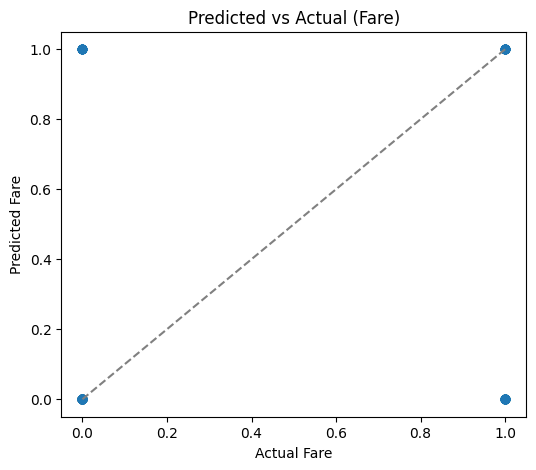

In [35]:
from IPython.display import Image, display
from pathlib import Path

OUTPUT_DIR = Path('/mnt/data/titanic_project_outputs')
image_path = OUTPUT_DIR / "linear_pred_vs_actual.png"
display(Image(filename=image_path))

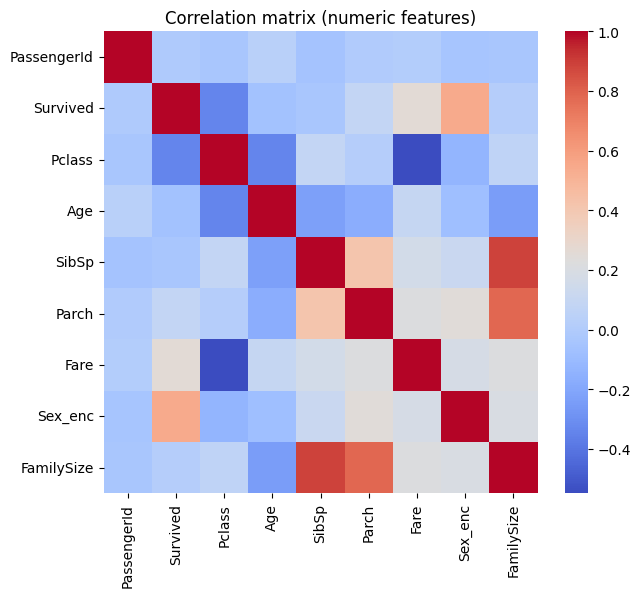

In [34]:
from IPython.display import Image, display
from pathlib import Path

OUTPUT_DIR = Path('/mnt/data/titanic_project_outputs')
image_path = OUTPUT_DIR / "corr_matrix.png"
display(Image(filename=image_path))

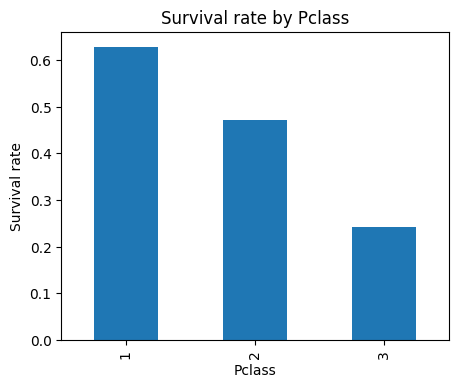

In [33]:
from IPython.display import Image, display
from pathlib import Path

OUTPUT_DIR = Path('/mnt/data/titanic_project_outputs')
image_path = OUTPUT_DIR / "survival_by_pclass.png"
display(Image(filename=image_path))

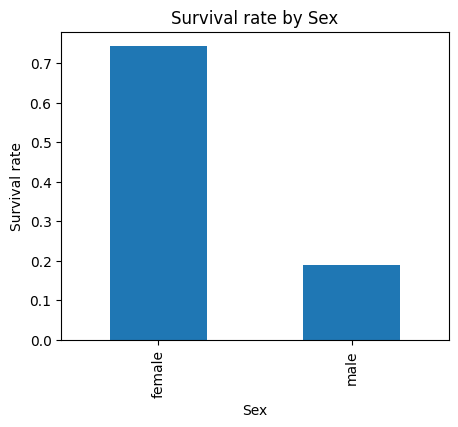

In [32]:
from IPython.display import Image, display
from pathlib import Path

OUTPUT_DIR = Path('/mnt/data/titanic_project_outputs')
image_path = OUTPUT_DIR / "survival_by_sex.png"
display(Image(filename=image_path))